In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wiki-data/wiki_data.csv


# Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

# Load Dataset

In [3]:
df = pd.read_csv("/kaggle/input/wiki-data/wiki_data.csv")
df.head()

Unnamed: 0                                               text
0           1  Anovo\n\nAnovo (formerly A Novo) is a computer...
1           2  Battery indicator\n\nA battery indicator (also...
2           3  Bob Pease\n\nRobert Allen Pease (August 22, 19...
3           4  CAVNET\n\nCAVNET was a secure military forum w...
4           5  CLidar\n\nThe CLidar is a scientific instrumen...

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10859 entries, 0 to 10858
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10859 non-null  int64 
 1   text        10859 non-null  object
dtypes: int64(1), object(1)
memory usage: 169.8+ KB


In [5]:
df.shape

(10859, 2)

In [6]:
# veri seti büyük olduğu için ilk 2000 satırı getirsin
df = df[:2000]

In [7]:
df.shape

(2000, 2)

# Text Preprocessing

In [8]:
# Metindeki standartlaştırma işlemlerini yapabilen fonksiyon yazılması
# - Büyük küçük harf dönüşümünün,
# - Noktalama işaretlerinin,
# - Numerik ifadeleri çıkarma işlemlerinin yapılması
    
def clean_text(text):
    # Normalizing Case Folding
    text = text.str.lower()
    # Punctuations
    text = text.str.replace(r'[^\w\s]', '',regex=True)
    text = text.str.replace("\n" , '',regex=True)
    # Numbers
    text = text.str.replace('\d', '',regex=True)
    return text

df["text"] = clean_text(df["text"])

In [9]:
df.head()

Unnamed: 0                                               text
0           1  anovoanovo formerly a novo is a computer servi...
1           2  battery indicatora battery indicator also know...
2           3  bob peaserobert allen pease august  â â june  ...
3           4  cavnetcavnet was a secure military forum which...
4           5  clidarthe clidar is a scientific instrument us...

In [10]:
# Metin içinde öznitelik yaparken, önemli olmayan kelimeleri çıkaracak fonksiyonun yazılması
# stopwordsleri silme

import nltk

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def remove_stopwords(text):
    sw = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
    return text

In [13]:
df["text"] = remove_stopwords(df["text"])

In [14]:
df["text"].head()

0    anovoanovo formerly novo computer services com...
1    battery indicatora battery indicator also know...
2    bob peaserobert allen pease august â â june an...
3    cavnetcavnet secure military forum became oper...
4    clidarthe clidar scientific instrument used me...
Name: text, dtype: object

In [15]:
# Metinde az tekrarlayan kelimelerin bulunması

pd.Series(' '.join(df['text']).split()).value_counts()[-1000:]

stumpssometimes    1
fresno             1
porteous           1
shankgiant         1
bootripping        1
                  ..
nif                1
standardsnet       1
patternsâ          1
domainsnetwork     1
fluidssolids       1
Name: count, Length: 1000, dtype: int64

In [16]:
# Metinde az tekrarlayan kelimeler metin içinden çıkartılması

delete = pd.Series(' '.join(df['text']).split()).value_counts()[-1000:]
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in delete))
df['text']

0       anovoanovo formerly novo computer services com...
1       battery indicatora battery indicator also know...
2       bob peaserobert allen pease august â â june an...
3       cavnetcavnet secure military forum became oper...
4       clidarthe clidar scientific instrument used me...
                              ...                        
1995    edinburgh calotype clubthe edinburgh calotype ...
1996    endrinendrin organochloride chemical formula c...
1997    ethylene glycol dinitrateethylene glycol dinit...
1998    forges de syamthe forges de syam syam forges f...
1999    frankkamenetskii theoryin combustion frankkame...
Name: text, Length: 2000, dtype: object

In [17]:
# Metinleri tokenize edip sonucunu gözlemlenmesi

df["text"].apply(lambda x: TextBlob(x).words)

0       [anovoanovo, formerly, novo, computer, service...
1       [battery, indicatora, battery, indicator, also...
2       [bob, peaserobert, allen, pease, august, â, â,...
3       [cavnetcavnet, secure, military, forum, became...
4       [clidarthe, clidar, scientific, instrument, us...
                              ...                        
1995    [edinburgh, calotype, clubthe, edinburgh, calo...
1996    [endrinendrin, organochloride, chemical, formu...
1997    [ethylene, glycol, dinitrateethylene, glycol, ...
1998    [forges, de, syamthe, forges, de, syam, syam, ...
1999    [frankkamenetskii, theoryin, combustion, frank...
Name: text, Length: 2000, dtype: object

In [18]:
# Lemmatizasyon işleminin yapılması
# kelimeleri yalın haline getirerek gösterir

df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


In [19]:
df.head()

Unnamed: 0                                               text
0           1  anovoanovo formerly novo computer service comp...
1           2  battery indicatora battery indicator also know...
2           3  bob peaserobert allen pea august â â june anal...
3           4  cavnetcavnet secure military forum became oper...
4           5  clidarthe clidar scientific instrument used me...

In [20]:
# Metindeki terimlerin frekanslarının bulunması

tf = df["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index() # kodu gÃ¼ncellemek gerekecek

tf.head()

index       0
0   rating  106.00
1  service 1341.00
2  company 2430.00
3    score  160.00
4    award  368.00

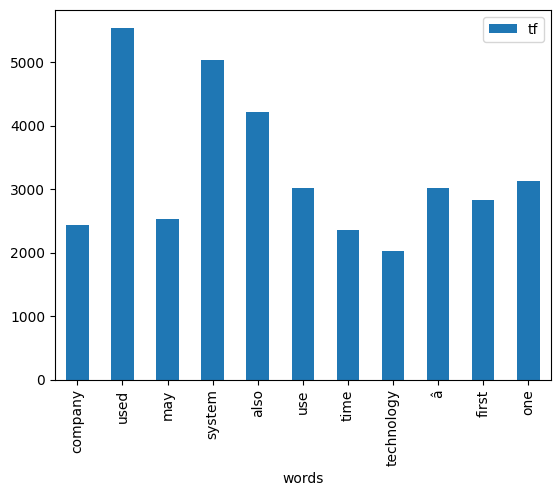

In [21]:
# Barplot grafiğinin oluşturulması

# Sütunların isimlendirilmesi
tf.columns = ["words", "tf"]

# 5000'den fazla geçen kelimelerin görselleştirilmesi
tf[tf["tf"] > 2000].plot.bar(x="words", y="tf")
plt.show()

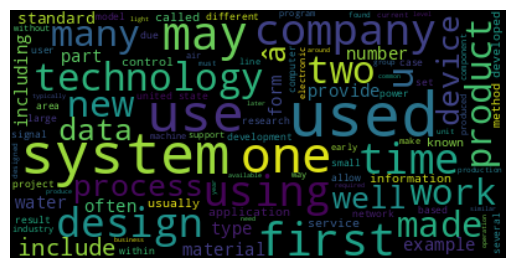

In [22]:
# Kelimeleri WordCloud ile düzenleme işleminin yapılması

# kelimelerin birleştirilmesi
text = " ".join(i for i in df["text"])

# wordcloud görselleştirmenin özelliklerinin belirlenmesi
wordcloud = WordCloud(max_font_size=50,
max_words=100,
background_color="black").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Structuring the code as functions

In [23]:
def wiki_preprocess(text, Barplot=False, Wordcloud=False):
    """
    Textler üzerinde ön işleme işlemleri yapar.

    :param text: DataFrame'deki textlerin olduğu değişken
    :param Barplot: Barplot görselleştirme
    :param Wordcloud: Wordcloud görselleştirme
    :return: text

    Example:
            wiki_preprocess(dataframe[col_name])

    """
    # Normalizing Case Folding
    text = text.str.lower()
    # Punctuations
    text = text.str.replace('[^\w\s]', '',regex=True)
    text = text.str.replace("\n", '',regex=True)
    # Numbers
    text = text.str.replace('\d', '',regex=True)
    # Stopwords
    sw = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
    # Rarewords / Custom Words
    delete = pd.Series(' '.join(text).split()).value_counts()[-1000:]
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in delete))


    if Barplot:
        # Terim Frekanslarının Hesaplanması
        tf = text.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
        # Sütunların isimlendirilmesi
        tf.columns = ["words", "tf"]
        # 5000'den fazla geçen kelimelerin görselleştirilmesi
        tf[tf["tf"] > 2000].plot.bar(x="words", y="tf")
        plt.show()

    if Wordcloud:
        # Kelimeleri birleştirdik
        text = " ".join(i for i in text)
        # wordcloud görselleştirmenin özelliklerini belirliyoruz
        wordcloud = WordCloud(max_font_size=50,
                              max_words=100,
                              background_color="black").generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

    return text


In [24]:
wiki_preprocess(df["text"])

0       anovoanovo formerly novo computer service comp...
1       battery indicatora battery indicator also know...
2       bob peaserobert allen pea august â â june anal...
3       cavnetcavnet secure military forum became oper...
4       clidarthe clidar scientific instrument used me...
                              ...                        
1995    edinburgh calotype clubthe edinburgh calotype ...
1996    endrinendrin organochloride chemical formula c...
1997    ethylene glycol dinitrateethylene glycol dinit...
1998    forge de syamthe forge de syam syam forge forg...
1999    frankkamenetskii theoryin combustion frankkame...
Name: text, Length: 2000, dtype: object

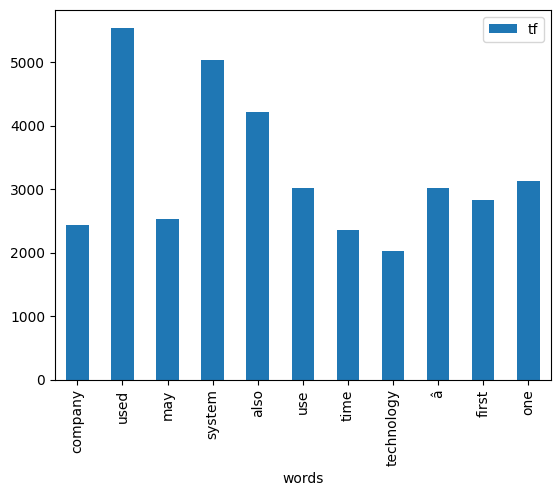

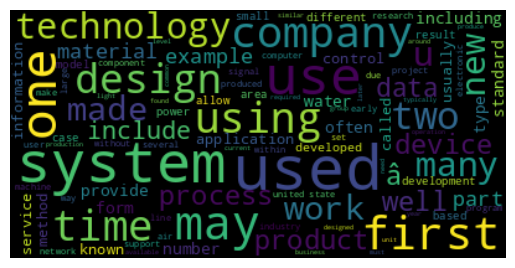

'anovoanovo formerly novo computer service company based beauvais france founded went public currently member cac smallit category service repair mobile news award four year row november score trustpilot rating site reviewer giving company lowest possible rating battery indicatora battery indicator also known battery gauge device give information battery usually visual indication battery state charge particularly important case battery electric vehiclesome automobile fitted battery condition meter monitor starter battery meter essentially voltmeter may also marked coloured zone easy visualization many newer car longer offer voltmeter ammeter instead vehicle typically light outline automotive battery somewhat misleading may confused indicator bad battery reality indicates problem vehicle charging system alternatively ammeter may fitted indicates whether battery charged discharged adjacent picture ammeter marked alternator symbol c charge discharge ammeter voltmeter individually together

In [25]:
wiki_preprocess(df["text"], True, True)